In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Proj4.ipynb")

# Project 4: Mongo 

## Due Date: Tuesday 5/4, 11:59 PM

In this project, we will be investigating how different database systems handle semi-structured JSON data. In particular, we will be placing emphasis on the use of MongoDB: a database system that stores data in a construct known as documents. These documents are very similar to the JSON objects we've explored in lecture with a few differences in representation and indexing that we will explore in the following questions. In this project, we will be working with the Yelp Academic Dataset which contains a dataset of `businesses`, `reviews`, and `users`. Due to the limitations of JupyterHub and the Mongo instances we are working with, `reviews` and `users` are truncated to 7500 reviews and 1000 users. We will be using the full `businesses` dataset, however.

Throughout the course of this project, you should hopefully understand what Mongo can (and cannot) do with regards to its documents and compare and contrast this to other data representation formats such as the relational and dataframe model.

## Scoring Breakdown
Question | Points
--- | ---
1a	| 1
1b  | 1
1c	| 1
1d	| 1
1e	| 2
1f  | 1
2a	| 1
2b	| 2
2c  | 2
3a	| 1
3b	| 1
3c	| 2
3d  | 1
3e  | 3
4a	| 1
4b	| 1
4c	| 1
4d  | 1
**Total** | 24

## Loading Up Mongo
We will be using Pymongo, a Python wrapper for MongoDB, for this project. Every student should have access to their own MongoDB instance, running on the localhost of your Datahub server. Be cautious with your queries, however: this is the first time Mongo has been run on Datahub so you might run into some hiccups along the way! After running the following cell, for the rest of the project, you can use the Python variables business, review, and user to access the corresponding collection.

In [2]:
import json
import pymongo

myclient = pymongo.MongoClient("mongodb://localhost")
mydb = myclient["yelp"]
business = mydb["businesses"]
review = mydb["reviews"]
user = mydb["users"]

## Troubleshooting
You might run into issues on the project where you are certain your code works but the output is incorrect. This may be because your collections have been corrupted. Run the following cell and uncomment the specific collections you would like to drop if you would like to remake your collections from scratch. **Be sure to re-run the Load Datasets cell if you drop your collections so you aren't working with empty collections!**

In [3]:
# RUN THIS CELL IF YOU WOULD LIKE TO REMAKE YOUR COLLECTIONS FROM SCRATCH. IF YOU DROP ANY COLLECTIONS,
# RE-RUN THE NEXT CELL TOO TO LOAD IN DATA.

# review.drop()
# business.drop()
# user.drop()

business = mydb["businesses"]
review = mydb["reviews"]
user = mydb["users"]

## Load Datasets
The following 2 cells will load the JSON datasets into the appropriate Mongo collections. These second cell will probably take a couple of minutes to run. Be sure to re-run this cell if you dropped your collection in the previous box. 

In [4]:
import zipfile
import os.path

if not os.path.isfile('yelp_academic_dataset_review.json'):
    with zipfile.ZipFile('yelp_academic_dataset_review.json.zip', 'r') as zip_ref:
        zip_ref.extractall()

if not os.path.isfile('yelp_academic_dataset_user.json'):
    with zipfile.ZipFile('yelp_academic_dataset_user.json.zip', 'r') as zip_ref:
        zip_ref.extractall()

if not os.path.isfile('yelp_academic_dataset_business.json'):
    with zipfile.ZipFile('yelp_academic_dataset_business.json.zip', 'r') as zip_ref:
        zip_ref.extractall()

In [5]:
# THIS CELL MAY TAKE AT MOST 5 MINUTES. BUT HOPEFULLY YOU WILL ONLY NEED TO RUN IT ONCE.
if business.count_documents({}) == 0:
    with open('yelp_academic_dataset_business.json', encoding='utf-8') as f:
        for line in f:
            business.insert_one(json.loads(line))

if review.count_documents({}) == 0:
    with open('yelp_academic_dataset_review.json', encoding='utf-8') as f:
        for line in f:
            review.insert_one(json.loads(line))
            
if user.count_documents({}) == 0:
    with open('yelp_academic_dataset_user.json', encoding='utf-8') as f:
        for line in f:
            user.insert_one(json.loads(line))

Let's take a quick look at our collections. For the command below, replace `user` with `review` or `business` to count the number of documents in each collection.

In [6]:
business.count_documents({})

160585

Now let's inspect our collections. Replace `business` with `review` and `user` to see the first document in each collection.

In [7]:
list(business.aggregate([{"$limit": 1}]))

[{'_id': ObjectId('608c91c0bd041ab900f9e080'),
  'business_id': '6iYb2HFDywm3zjuRg0shjw',
  'name': 'Oskar Blues Taproom',
  'address': '921 Pearl St',
  'city': 'Boulder',
  'state': 'CO',
  'postal_code': '80302',
  'latitude': 40.0175444,
  'longitude': -105.2833481,
  'stars': 4.0,
  'review_count': 86,
  'is_open': 1,
  'attributes': {'RestaurantsTableService': 'True',
   'WiFi': "u'free'",
   'BikeParking': 'True',
   'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",
   'BusinessAcceptsCreditCards': 'True',
   'RestaurantsReservations': 'False',
   'WheelchairAccessible': 'True',
   'Caters': 'True',
   'OutdoorSeating': 'True',
   'RestaurantsGoodForGroups': 'True',
   'HappyHour': 'True',
   'BusinessAcceptsBitcoin': 'False',
   'RestaurantsPriceRange2': '2',
   'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casua

If you see a document containing a business named `Oskar Blues Taproom` when you run the command above, it means that our JSON data has successfully been imported into the collection! Now we can get started with exploring Mongo in a bit more detail. Run the following two cells for grading purposes.

In [8]:
! mkdir -p results

In [9]:
import bson
from bson.objectid import ObjectId
import pickle
import pandas as pd

# Question 1: Basic MQL

### Question 1a

In lecture, we discussed how one could find specific attributes from a JSON object using dot notation. 

While you can still use the dot notation in queries, PyMongo represents documents returned from Mongo queries using Python dictionaries, making it convenient to manipulate JSON using a mix of Mongo queries and array indexing. Specifically, given the result of a retrieval `find` query, you can look up the third document by appending `[2]`. Then, given this document, you can look up the field `'amount'` by appending `['amount']` etc., adding multiple square brackets as needed to "walk down" the JSON tree representation via `collection.find(...)[2]['amount']`. 

As a warmup to get you familiarized with PyMongo syntax, find the Tuesday hours for the restaurant named Legal Sea Foods at 100 Huntington Ave, Boston, MA. Be careful! There are many Legal Sea Foods in Boston!

In [10]:
question_1a_str = business.find({"name":"Legal Sea Foods", "address":"100 Huntington Ave",
               "city":"Boston", "state":"MA"})[0]["hours"]["Tuesday"]
question_1a_str

'12:0-21:0'

In [11]:
# Do not delete/edit this cell
pickle.dump(question_1a_str, open("results/result_1a.p","wb"))

In [12]:
grader.check("q1a")

q1a passed!

### Question 1b
Now let's get some practice with aggregation and filtering. Our goal is to write a query that computes the average star rating for all businesses in Colorado with 30 reviews or greater. However, this won't be as easy as setting the state to CO! If we inspect this dataset more closely, we will notice that some cities are not matched up with the right states. As an example, run `list(business.find({"state": "CA"}))` below.

In [13]:
print(list(business.find({"state": "CA"})))

[{'_id': ObjectId('608c91c2bd041ab900f9e79b'), 'business_id': 'SNCRnaSy6E5fHgQuoCmmbQ', 'name': 'Katia Photography', 'address': '', 'city': 'Portland', 'state': 'CA', 'postal_code': '97007', 'latitude': 45.4501529, 'longitude': -122.8849111, 'stars': 5.0, 'review_count': 11, 'is_open': 1, 'attributes': {'BusinessAcceptsBitcoin': 'False', 'BusinessAcceptsCreditCards': 'True', 'WiFi': "u'no'"}, 'categories': 'Shopping, Clothing Rental, Event Planning & Services, Fashion, Event Photography, Photographers, Session Photography', 'hours': {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', 'Wednesday': '8:0-22:0', 'Thursday': '8:0-22:0', 'Friday': '8:0-22:0', 'Saturday': '8:0-22:0', 'Sunday': '8:0-22:0'}}, {'_id': ObjectId('608c91debd041ab900fa5807'), 'business_id': 'cjwnQMQOGOYgB5uNmiYWLA', 'name': 'Verizon Authorized Retailer - GoWireless', 'address': '4655 SW Griffith Dr, Ste 125', 'city': 'Beaverton', 'state': 'CA', 'postal_code': '97005', 'latitude': 45.486312, 'longitude': -122.796487, 'star

Notice how cities like Portland, Atlanta, and Austin are classified as California cities! However, the latitude and longitude is generally correct. The latitude of Colorado is between 37 and 41 inclusive and the longitude is between -109 and -102 inclusive. Now, use this to find the average star rating of all businesses in this range with 30 reviews or greater.

Recall that in SQL, we would use a GROUP BY with the AVG aggregation function. In Mongo, we use an aggregation pipeline, comprised of multiple stages. Each stage transforms the documents in some way. Pipeline stages do not need to produce one output document for every input document. For example, some stages may generate new documents or filter out documents.

**HINT**: as in the previous question, you may find it helpful to use the PyMongo array notation to extract the pertinent information once you have composed the right Mongo aggregation query.

In [14]:
# Our goal is to write a query that computes the average star 
# rating for all businesses in Colorado with 30 reviews or greater.

In [15]:
new = business.find({"latitude": { '$gte': 37, '$lte': 41}, "longitude": 
               {'$gte': -109, '$lte': -102}, 'review_count': {'$gte': 30}})


In [16]:
ye = list(business.aggregate([{'$match' : {"latitude": { '$gte': 37, '$lte': 41}, 
                                           "longitude": { '$gte': -109, '$lte': -102}, 
                                           'review_count': {'$gte': 30}}},
                              {'$group' : {"_id": "$state", 
                                           "average" : {"$avg" : '$stars'}}}]))[0]['average']
ye

3.6735412474849096

In [17]:
question_1b_str = list(business.aggregate([{'$match' : {"latitude": { '$gte': 37, '$lte': 41}, 
                                           "longitude": { '$gte': -109, '$lte': -102}, 
                                           'review_count': {'$gte': 30}}},
                                           {'$group' : {"_id": "$state", 
                                           "average" : {"$avg" : '$stars'}}}]))[0]['average']

In [18]:
# Do not delete/edit this cell
pickle.dump(question_1b_str, open("results/result_1b.p","wb"))

In [19]:
grader.check("q1b")

q1b passed!

### Question 1c

In this question, we will explore aggregation and grouping further. We will also make use of the `$project` operator which allows us to output documents with certain fields of our choosing. 

For this question, we would like to create an aggregation pipeline to find towns in each state with the highest average number of stars. **We will only consider towns with greater than or equal to 5 reviews in total across all the restaurants in that town so that the average is meaningful.** Your final output should contain exactly two fields: `city_state` which is the name of the town with the highest value of average stars in the state concatenated with a comma followed by the state initials and `averageStars` which contains the average number of stars for the corresponding town. To ensure your output is consistent with the autograder, sort in descending order by `averageStars` and break ties by sorting second on `city_state` in alphabetical order.

As a concrete example, imagine that Berkeley and Austin have the highest average stars in California and Texas respectively (and both have more than or equal to 5 total reviews). If Berkeley and Austin both have an average star rating of 5.0, your final output should be:

```
{'averageStars': 5.0, 'city_state': 'Austin, TX'}
{'averageStars': 5.0, 'city_state': 'Berkeley, CA'}
```

**NOTE:** You will provide a pipeline to `business.aggregate(...)` as your solution. Make sure that you save your pipeline to `q1c_pipeline` or you will not pass the autograder! 

**HINT:** You may find the `concat` operator helpful. See: https://docs.mongodb.com/manual/reference/operator/aggregation/concat/

In [20]:
q1c_pipeline = [{'$project': { 'city' : 1, 'state' : 1, 'review_count' : 1, 'stars' : 1}}, 
{"$group" : {"_id" : {"city" : "$city", "state" : "$state"}, "average" : {"$avg" : "$stars"}, "count" : {"$sum" : "$review_count"}}},
{"$match" : {"count" : {"$gte" : 5}}},
{"$sort" : {"average" : -1}},
{"$group" : {"_id" : {"state" : "$_id.state"},
"city" : {"$first" : "$_id.city"},
"averageStars" : {"$first" : "$average"}}},
{"$project" : {"_id" : 0, "averageStars" : 1, "city_state" : {"$concat" : ["$city", ", ", "$_id.state"]}}},
{"$sort" : {"city_state" : 1}}]

cur = business.aggregate(q1c_pipeline)

In [21]:
# Do not delete/edit this cell
myclient = pymongo.MongoClient("mongodb://localhost")
mydb = myclient["yelp"]
business = mydb["businesses"]
pipeline_for_test_1c = q1c_pipeline[:]
cur_test_1c = business.aggregate(pipeline_for_test_1c)
cur_test_1c = pickle.dump(list(cur_test_1c), open("results/result_1c.p","wb"))

In [22]:
grader.check("q1c")

q1c passed!

### Question 1d

In class, we've described structured (rectangular) data as well as semi-structured data. We haven't quite covered unstructured data -- this is basically free-form text. Often, in semi-structured JSON you may have unstructured text data embedded within, such as the text field in the review collection.

MongoDB allows us to build a so-called `text index` to retrieve the relevant document based on keywords found in text in a predefined field. This index converts our free-form text into a structure that allows us to easily look up documents by its contents. To leverage this text search capability, we must first build a text index on the text field. This has been done for you.

We will then use this text index to do basic sentiment analysis and find all the restaurants we should avoid! Using the text index given, write a query to find all the reviews with "disgusting", "horrible", "horrid", "gross", "bad", or "hate". To use the text index, use the keywords `$text` and `$search` as detailed here: https://docs.mongodb.com/manual/text-search/. Once the index has been created (i.e. you run the following cell at least once), the `$text` and `$search` commands should work immediately contingent on proper syntax.

Enter your query after `cursor` and use the pre-written code to read some of the reviews. Your query should be of the form `review.find({...})`.  How many reviews contain either of these 6 words?

In [23]:
from pymongo import TEXT

# We create a text index here.
if 'text_text' not in review.index_information():
    review.create_index([('text', TEXT)])

cursor = review.find({"$text" : {"$search" : "disgusting horrible horrid gross bad hate"}})

limit = 0
for business_review in cursor:
    print(business_review["text"])
    limit += 1
    if limit == 2:
        break
        
question_1d_str = cursor.count()

I had been coming here for years, but Habana's has lost it ways. The food was so bad and expensive.  Bad food that cost a lot leaves you feeling more than a little ripped off.  The drink menu does not have prices,  this is because a glass of wine is 10 dollars.  The $23 Lechon Asado could have been mistaken for bad jerky.  
There are NOW much better Cuban here in Austin, let this one fade away.
I don't have any idea why but my coffee was so bad I couldn't drink it. The same dark roast I order at other nearby locations and love yet so bad here. I thought it could be a one bad day thing so I gave it another try and got the same horrible results. When your morning starts with coffee you can't drink you are in for a long day. I can only guess that employees didn't make the coffee as ordered or else they are using water from Lake Apopka.


<ipython-input-23-b9226ff2717d>:16: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  question_1d_str = cursor.count()


In [24]:
# Do not delete/edit this cell
pickle.dump(question_1d_str, open("results/result_1d.p","wb"))

In [25]:
grader.check("q1d")

q1d passed!

### Question 1e

Now let's learn Mongo updates, deletions, and creation. Create a new collection called `reviews_boolean` which is the exact same as `reviews` EXCEPT there is a new field called `to_avoid` which is the string "true"  if the review `text` contains the words "disgusting", "horrid", "horrible", "gross", "bad", or "hate" and the string "false" if not.  

This is a tricky task! We have not discussed creation, updates, or insertions in great detail during lecture but luckily, Mongo uses a similar approach to SQL. 

*Insertions*: In order to insert into a document, you may use the functions [`review_boolean.insert_one(...)`](https://docs.mongodb.com/manual/reference/method/db.collection.insertOne/) or [`review_boolean.insert_many(...)`](https://docs.mongodb.com/manual/reference/method/db.collection.insertMany/). These functions take in a document or a list of documents and inserts them into the collection. 

*Updates*: In order to update a document, you may use the functions [`review_boolean.update_one(...)`](https://docs.mongodb.com/manual/reference/method/db.collection.updateOne/) or [`review_boolean.update_many(...)`](https://docs.mongodb.com/manual/reference/method/db.collection.updateMany/). These functions take in two parameters. The first specifies which documents should be modified. If the first parameter is `{}`, this indicates that all documents should be updated. However, you can put a more specific filter here if you would like. The second parameter specifies what you would like to update your field to (the [`$set`](https://docs.mongodb.com/manual/reference/operator/update/set/) operator may come in handy here). Recall that in our SQL model, updates are performed as `UPDATE ... SET ... WHERE ...`. In our case, the first ellipsis corresponds to `reviews_boolean`, the second ellipsis corresponds to the second parameter of `update_*`, and the third ellipsis corresponds to the first parameter of `update_*`.

*Creation*: We handle creation of the collection for you. But in Pymongo, creation of a collection is as simple as writing `variable_name = db[collection_name]` where db is the the Pymongo database object variable you have already created.

Some additional reminders and hints:
- The empty collection `reviews_boolean` has already been created for you and is stored in the variable `review_boolean`
- `review.find({})` creates an iterator that allows you to iterate over every document in `review`
- Do not forget that in order to pass the hidden tests, the `to_avoid` field must exist for every document in `reviews_boolean`!

In [26]:
# Create a new collection called reviews_boolean which is the exact same as reviews EXCEPT there 
# is a new field called to_avoid which is the string "true" if the review text contains the words "disgusting"
# "horrid", "horrible", "gross", "bad", or "hate" and the string "false" if not.

In [29]:
review_boolean.drop() # UNCOMMENT THIS IF RUNNING INTO DUPLICATEKEYERROR

# YOUR ANSWER BEGINS HERE
review_boolean = mydb["reviews_boolean"]
    
for each in review.find({}):
    review_boolean.insert_one(each)
    
if 'text_text' not in review_boolean.index_information():
    review_boolean.create_index([('text', TEXT)])
    
false = {"$set" : {'to_avoid' : "false"}}
review_boolean.update_many({}, false)

cond_true = {"$text" : {"$search" : "disgusting horrible horrid gross bad hate"}}
true = {"$set" : {'to_avoid' : "true"}}
review_boolean.update_many(cond_true, true)

list(review_boolean.find({}))

[{'_id': ObjectId('608c9260bd041ab900fc53c9'),
  'review_id': 'lWC-xP3rd6obsecCYsGZRg',
  'user_id': 'ak0TdVmGKo4pwqdJSTLwWw',
  'business_id': 'buF9druCkbuXLX526sGELQ',
  'stars': 4.0,
  'useful': 3,
  'funny': 1,
  'cool': 1,
  'text': "Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. \n\nAfter reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don't offer half portions of pasta we each ordered the entree size and split them. We chose the tag

In [30]:
# Do not delete/edit this cell
import pickle
myclient = pymongo.MongoClient("mongodb://localhost")
mydb = myclient["yelp"]
reviews_boolean_1e = mydb["reviews_boolean"]
pickle.dump(list(reviews_boolean_1e.find({}, {'_id': 0})), open("results/result_1e_1.p","wb"))
pickle.dump(mydb.list_collection_names(), open("results/result_1e_2.p","wb"))

In [31]:
grader.check("q1e")

q1e passed!

### Question 1f

Now, you had a change of heart: you decide that it's unfair to label restaurants as `to_avoid` without at least giving them a chance! Remove the `to_avoid` field from the `reviews_boolean` collection. Calculate the `difference` between the data size of `reviews_boolean` with the `to_avoid` field and without it. The code for making this calculation is provided but it is up to you to actually remove the field. Before running the next cell, make sure to re-run your cell for 1e so you don't get a difference of 0!

*Deletions*: Deletions in Mongo make use of the `review_boolean.update_one(...)` or `review_boolean.update_many(...)` functionality discussed in Question 1e. However, this time, instead of using the `$set` operator which allows for the creation of new fields, we will use the [`$unset`](https://docs.mongodb.com/manual/reference/operator/update/unset/) operator which deletes them! Very tidy!

Before running the next cell, make sure to re-run your cell for 1e so you don't get a difference of 0!

In [32]:
with_avoid = mydb.command("collstats", "reviews_boolean")['size']

# YOUR ANSWER BEGINS HERE
review_boolean.update_many({}, {"$unset" : {"to_avoid" : ""}})
# END

without_avoid = mydb.command("collstats", "reviews_boolean")['size']
difference = with_avoid - without_avoid
difference

149272

In [33]:
# Do not delete/edit this cell
pickle.dump(difference, open("results/result_1f.p","wb"))

In [34]:
grader.check("q1f")

q1f passed!

## Question 2: JSON and Relational Models

### Question 2a

Now we have a good idea of how to do retrieval, aggregation, and updates in Mongo. But we haven't talked about why we
would want to use Mongo to store JSON! In order to explore this, let's take another look at the `business`
collection. We will look at the first two entries.

In [35]:
list(business.aggregate([{"$limit": 2}]))

[{'_id': ObjectId('608c91c0bd041ab900f9e080'),
  'business_id': '6iYb2HFDywm3zjuRg0shjw',
  'name': 'Oskar Blues Taproom',
  'address': '921 Pearl St',
  'city': 'Boulder',
  'state': 'CO',
  'postal_code': '80302',
  'latitude': 40.0175444,
  'longitude': -105.2833481,
  'stars': 4.0,
  'review_count': 86,
  'is_open': 1,
  'attributes': {'RestaurantsTableService': 'True',
   'WiFi': "u'free'",
   'BikeParking': 'True',
   'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",
   'BusinessAcceptsCreditCards': 'True',
   'RestaurantsReservations': 'False',
   'WheelchairAccessible': 'True',
   'Caters': 'True',
   'OutdoorSeating': 'True',
   'RestaurantsGoodForGroups': 'True',
   'HappyHour': 'True',
   'BusinessAcceptsBitcoin': 'False',
   'RestaurantsPriceRange2': '2',
   'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casua

<!-- BEGIN QUESTION -->

What are two pros of storing this data in MongoDB with JSON over a relational database management system such as Postgres?
Please reference specific examples from the `business` collection to back up your claims. 

<!--
BEGIN QUESTION
name: q2a
manual: true
points: 1
-->

* One pro is that there is flexibility in the set of attributes we can store for each document, since they can be nested and be multivalued. In the business collection above, there isn't a fixed schema we're working with. The collections contain fields like attributes that contain dictionaries, which are a set of values by nature so we see the nested structure.
* Another pro is that the data is self-describing. Since the key-value format forces the data to list what it's talking about explicitly, and since we're allowed to nest values within each other, we get a taxonomy of sorts that makes the relationships within the data more understandable and thus more human-readable.

<!-- END QUESTION -->



### Question 2b

It seems like MongoDB is getting all the love when it comes to JSON support! However, modern iterations of relational databases
such as Postgres 9.3+ also have [excellent JSON functionality](https://www.postgresql.org/docs/9.3/functions-json.html) as we will soon explore in this task. First, let's set up a
bit of scaffolding. The following cell will import the `yelp_academic_dataset_review.json` data into a table called `reviews`.

In [36]:
%reload_ext sql
%sql postgresql://jovyan@127.0.0.1:5432/postgres

! psql -h localhost -c 'DROP DATABASE IF EXISTS yelp'
! psql -h localhost -c 'CREATE DATABASE yelp'
! psql -h localhost -d yelp -c 'DROP TABLE IF EXISTS reviews'
! psql -h localhost -d yelp -c 'CREATE TABLE reviews(data TEXT);'
! cat yelp_academic_dataset_review.json | psql -h localhost -d yelp -c "COPY reviews (data) FROM STDIN;"
%sql \l

DROP DATABASE
CREATE DATABASE
NOTICE:  table "reviews" does not exist, skipping
DROP TABLE
CREATE TABLE
COPY 7500
 * postgresql://jovyan@127.0.0.1:5432/postgres
6 rows affected.


Name,Owner,Encoding,Collate,Ctype,Access privileges
jovyan,jovyan,UTF8,en_US.utf8,en_US.utf8,None
postgres,jovyan,UTF8,en_US.utf8,en_US.utf8,None
template0,jovyan,UTF8,en_US.utf8,en_US.utf8,=c/jovyanjovyan=CTc/jovyan
template1,jovyan,UTF8,en_US.utf8,en_US.utf8,=c/jovyanjovyan=CTc/jovyan
ucb_buildings,jovyan,UTF8,en_US.UTF-8,en_US.UTF-8,None
yelp,jovyan,UTF8,en_US.utf8,en_US.utf8,None


Run the next two cells to observe how this new `reviews` table looks. **Please note that the `data` column is stored as TEXT and not as JSON.**

In [37]:
%sql postgresql://jovyan@127.0.0.1:5432/yelp

In [38]:
%%sql
SELECT * FROM public.reviews LIMIT 2;

   postgresql://jovyan@127.0.0.1:5432/postgres
 * postgresql://jovyan@127.0.0.1:5432/yelp
2 rows affected.


data
"{""review_id"":""lWC-xP3rd6obsecCYsGZRg"",""user_id"":""ak0TdVmGKo4pwqdJSTLwWw"",""business_id"":""buF9druCkbuXLX526sGELQ"",""stars"":4.0,""useful"":3,""funny"":1,""cool"":1,""text"":""Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. After reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don't offer half portions of pasta we each ordered the entree size and split them. We chose the tagliatelle bolognese and a four cheese filled pasta in a creamy sauce with bacon, asparagus and grana frita. Both were very good. We split a secondi which was the special Berkshire pork secreto, which was described as a pork skirt steak with garlic potato purée and romanesco broccoli (incorrectly described as a romanesco sauce). Some tables received bread before the meal but for some reason we did not. Management also seems capable for when the tenants in the apartment above began playing basketball she intervened and also comped the tables a dessert. We ordered the apple dumpling with gelato and it was also quite tasty. Portions are not huge which I particularly like because I prefer to order courses. If you are someone who orders just a meal you may leave hungry depending on you appetite. Dining room was mostly younger crowd while the bar was definitely the over 40 set. Would recommend that the naysayers return to see the improvement although I personally don't know the former glory to be able to compare. Easy access to downtown Salem without the crowds on this month of October."",""date"":""2014-10-11 03:34:02""}"
"{""review_id"":""8bFej1QE5LXp4O05qjGqXA"",""user_id"":""YoVfDbnISlW0f7abNQACIg"",""business_id"":""RA4V8pr014UyUbDvI-LW2A"",""stars"":4.0,""useful"":1,""funny"":0,""cool"":0,""text"":""This store is pretty good. Not as great as Walmart (or my preferred, Milford Target), but closer and in a easier area to get to. The store itself is pretty clean and organized, the staff are friendly (most of the time), and BEST of all is the Self Checkout this store has! Great clearance sections throughout, and great prices on everything in the store, in general (they pricematch too!). Christian, Debbie, Jen and Hanna are all very friendly, helpful, sensitive to all customer needs. Definitely one of the better Target locations in the area, and they do a GREAT job assisting customers for being such a busy store. Located directly in the Framingham Mall on Cochituate Rd / Route 30. 4 stars."",""date"":""2015-07-03 20:38:25""}"


Observe how the reviews table consists of one column named `data`. This column contains all the JSON documents in the 
reviews collection *in text format*. Use [Postgres' JSON functions](https://www.postgresql.org/docs/9.3/functions-json.html) to write a query that converts the JSON fields into their own columns. To be more concrete, your query should contain 8 columns: `review_id`, `user_id`, `business_id`, `stars`, `useful`, `funny`, `cool`, and `text`. All of these columns should be `TEXT` columns. Each row should correspond to one JSON document. Be sure to `ORDER BY review_id` and `LIMIT 10` so your output corresponds with the autograder. We will also need Pandas for this question's autograder. We will also use Pandas rather extensively in the next question so we will import it in the following cell.

In [39]:
import pandas as pd

In [40]:
%%sql
DROP VIEW IF EXISTS json_data;

CREATE OR REPLACE VIEW json_data AS
Select CAST(REGEXP_REPLACE(data, '[\n\r]+', '', 'g') AS JSON) AS data
From public.reviews;

Select *
From json_data
Limit 1;

   postgresql://jovyan@127.0.0.1:5432/postgres
 * postgresql://jovyan@127.0.0.1:5432/yelp
Done.
Done.
1 rows affected.


data
"{'review_id': 'lWC-xP3rd6obsecCYsGZRg', 'user_id': 'ak0TdVmGKo4pwqdJSTLwWw', 'business_id': 'buF9druCkbuXLX526sGELQ', 'stars': 4.0, 'useful': 3, 'funny': 1, 'cool': 1, 'text': ""Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. After reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don't offer half portions of pasta we each ordered the entree size and split them. We chose the tagliatelle bolognese and a four cheese filled pasta in a creamy sauce with bacon, asparagus and grana frita. Both were very good. We split a secondi which was the special Berkshire pork secreto, which was described as a pork skirt steak with garlic potato purée and romanesco broccoli (incorrectly described as a romanesco sauce). Some tables received bread before the meal but for some reason we did not. Management also seems capable for when the tenants in the apartment above began playing basketball she intervened and also comped the tables a dessert. We ordered the apple dumpling with gelato and it was also quite tasty. Portions are not huge which I particularly like because I prefer to order courses. If you are someone who orders just a meal you may leave hungry depending on you appetite. Dining room was mostly younger crowd while the bar was definitely the over 40 set. Would recommend that the naysayers return to see the improvement although I personally don't know the former glory to be able to compare. Easy access to downtown Salem without the crowds on this month of October."", 'date': '2014-10-11 03:34:02'}"


In [41]:
%%sql
Select data::json->>'review_id' AS review_id,
        data::json->>'user_id' AS user_id,
        data::json->>'business_id' AS business_id,
        data::json->>'stars' AS stars,
        data::json->>'useful' AS useful,
        data::json->>'funny' AS funny,
        data::json->>'cool' AS cool,
        data::json->>'text' AS text
From json_data
Limit 1;

   postgresql://jovyan@127.0.0.1:5432/postgres
 * postgresql://jovyan@127.0.0.1:5432/yelp
1 rows affected.


review_id,user_id,business_id,stars,useful,funny,cool,text
lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,"Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. After reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don't offer half portions of pasta we each ordered the entree size and split them. We chose the tagliatelle bolognese and a four cheese filled pasta in a creamy sauce with bacon, asparagus and grana frita. Both were very good. We split a secondi which was the special Berkshire pork secreto, which was described as a pork skirt steak with garlic potato purée and romanesco broccoli (incorrectly described as a romanesco sauce). Some tables received bread before the meal but for some reason we did not. Management also seems capable for when the tenants in the apartment above began playing basketball she intervened and also comped the tables a dessert. We ordered the apple dumpling with gelato and it was also quite tasty. Portions are not huge which I particularly like because I prefer to order courses. If you are someone who orders just a meal you may leave hungry depending on you appetite. Dining room was mostly younger crowd while the bar was definitely the over 40 set. Would recommend that the naysayers return to see the improvement although I personally don't know the former glory to be able to compare. Easy access to downtown Salem without the crowds on this month of October."


In [42]:
%%sql result_2b <<
Select data::json->>'review_id' AS review_id,
        data::json->>'user_id' AS user_id,
        data::json->>'business_id' AS business_id,
        data::json->>'stars' AS stars,
        data::json->>'useful' AS useful,
        data::json->>'funny' AS funny,
        data::json->>'cool' AS cool,
        data::json->>'text' AS text
From json_data
ORDER BY review_id
LIMIT 10;

   postgresql://jovyan@127.0.0.1:5432/postgres
 * postgresql://jovyan@127.0.0.1:5432/yelp
10 rows affected.
Returning data to local variable result_2b


In [43]:
# Do not delete/edit this cell
result_2b.DataFrame().to_csv('results/result_2b.csv', index=False)

In [44]:
grader.check("q2b")

q2b passed!

### Question 2c

One important aspect of data engineering that we have not referred to yet are joins. We saw, through the use of indices, selection/projection pushdown, and various physical implementations (as well as orderings), joins could be done quite efficiently in relational SQL based databases. How do joins fare in Mongo where the data stored is inherently semistructured? Let's investigate! For this question, we have provided you access to the tables `business_complete` and `review_complete` which contain the business and review collections in relational form as described in 2b (the columns of the relations
are fields in the JSON document). Each relation has its respective id (`business_id` or `review_id`) column as its primary key.

In [45]:
! psql -h localhost -d yelp -c 'DROP TABLE IF EXISTS business_complete'
! psql -h localhost -d yelp -c 'CREATE TABLE business_complete(business_id TEXT PRIMARY KEY, name TEXT, address TEXT, city TEXT, state TEXT, postal_code TEXT, latitude TEXT,longitude TEXT, stars TEXT, review_count TEXT, is_open TEXT, attributes TEXT, categories TEXT, hours TEXT);'
! psql -h localhost -d yelp -c 'DROP TABLE IF EXISTS review_complete'
! psql -h localhost -d yelp -c 'CREATE TABLE review_complete(review_id TEXT PRIMARY KEY, user_id TEXT, business_id TEXT, stars TEXT, useful TEXT, funny TEXT, cool TEXT,text TEXT);'
! cat business.csv | psql -h localhost -d yelp -c "COPY business_complete (business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours) FROM STDIN CSV HEADER;"
! cat review.csv | psql -h localhost -d yelp -c "COPY review_complete (review_id, user_id, business_id, stars, useful, funny, cool, text) FROM STDIN CSV HEADER;"

NOTICE:  table "business_complete" does not exist, skipping
DROP TABLE
CREATE TABLE
NOTICE:  table "review_complete" does not exist, skipping
DROP TABLE
CREATE TABLE
COPY 35
COPY 7500


Let's take a look at how `review_complete` looks.

In [46]:
%%sql
SELECT * FROM public.business_complete LIMIT 2;

   postgresql://jovyan@127.0.0.1:5432/postgres
 * postgresql://jovyan@127.0.0.1:5432/yelp
2 rows affected.


business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
extrX1RLZEOq6VXN5SvnTw,Fiskie's Cafe,27 Harbor Point Blvd,Dorchester,MA,02125,42.318905,-71.042273,3.5,32,1,"{""BikeParking"":""False"",""NoiseLevel"":""u'average'"",""Ambience"":""{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}"",""BusinessAcceptsBitcoin"":""False"",""Alcohol"":""u'none'"",""RestaurantsAttire"":""u'casual'"",""RestaurantsPriceRange2"":""2"",""WiFi"":""u'no'"",""OutdoorSeating"":""True"",""RestaurantsTakeOut"":""True"",""RestaurantsDelivery"":""True"",""Caters"":""True"",""GoodForKids"":""True"",""RestaurantsReservations"":""None"",""GoodForMeal"":""{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': True, 'breakfast': False}"",""RestaurantsGoodForGroups"":""True"",""HasTV"":""False"",""BusinessAcceptsCreditCards"":""True"",""BusinessParking"":""{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}""}","Burgers, American (Traditional), Asian Fusion, Chinese, Restaurants, Mediterranean","{""Monday"":""11:0-21:0"",""Tuesday"":""11:0-21:0"",""Wednesday"":""11:0-21:0"",""Thursday"":""11:0-21:0"",""Friday"":""11:0-21:0"",""Saturday"":""11:0-20:0"",""Sunday"":""11:0-20:0""}"
A3NrsiMLUmlbl5zE22O9XA,Cronin's Landing Apartments,237 Moody St,Waltham,MA,02453,42.3722977,-71.236948,3.0,20,1,"{""ByAppointmentOnly"":""True"",""BusinessAcceptsCreditCards"":""False""}","Apartments, Real Estate, Home Services, Property Management","{""Monday"":""10:0-18:0"",""Tuesday"":""10:0-18:0"",""Wednesday"":""10:0-18:0"",""Thursday"":""10:0-18:0"",""Friday"":""10:0-18:0"",""Saturday"":""10:0-17:0"",""Sunday"":""10:0-17:0""}"


At this current moment in time, Mongo only supports left outer joins. This is what we will compare against SQL. 
Provided for you below is the EXPLAIN plan for a Mongo left outer join between `review` and `business`. For more information on what each aspect of `$lookup` does, refer to https://docs.mongodb.com/manual/reference/operator/aggregation/lookup/.

In [47]:
pipeline = [
	{
		"$lookup":
		{
			"from": "business",
			"localField": "business_id",
			"foreignField": "business_id",
			"as": "business_info"
		}
	}
]
mydb.command('explain', {'aggregate': 'review', 'pipeline': pipeline, 'cursor': {}}, verbosity='executionStats')

{'serverInfo': {'host': 'jupyter-tenzinchoezinn',
  'port': 27017,
  'version': '3.6.23',
  'gitVersion': 'd352e6a4764659e0d0350ce77279de3c1f243e5c'},
 'stages': [{'$cursor': {'query': {},
    'queryPlanner': {'plannerVersion': 1,
     'namespace': 'yelp.review',
     'indexFilterSet': False,
     'parsedQuery': {},
     'winningPlan': {'stage': 'EOF'},
     'rejectedPlans': []},
    'executionStats': {'executionSuccess': True,
     'nReturned': 0,
     'executionTimeMillis': 0,
     'totalKeysExamined': 0,
     'totalDocsExamined': 0,
     'executionStages': {'stage': 'EOF',
      'nReturned': 0,
      'executionTimeMillisEstimate': 0,
      'works': 1,
      'advanced': 0,
      'needTime': 0,
      'needYield': 0,
      'saveState': 1,
      'restoreState': 1,
      'isEOF': 1,
      'invalidates': 0}}}},
  {'$lookup': {'from': 'business',
    'as': 'business_info',
    'localField': 'business_id',
    'foreignField': 'business_id'}}],
 'ok': 1.0}

Now write the same left outer join in SQL which we will run on Postgres.

In [48]:
sql_join_str = "Select * From public.review_complete AS r Left Join public.business_complete AS b On r.business_id = b.business_id"
!psql -h localhost -d yelp -c "explain analyze $sql_join_str"

                                                          QUERY PLAN                                                           
-------------------------------------------------------------------------------------------------------------------------------
 Hash Left Join  (cost=13.82..778.08 rows=15792 width=704) (actual time=0.091..4.433 rows=7500 loops=1)
   Hash Cond: (r.business_id = b.business_id)
   ->  Seq Scan on review_complete r  (cost=0.00..721.92 rows=15792 width=256) (actual time=0.012..2.344 rows=7500 loops=1)
   ->  Hash  (cost=11.70..11.70 rows=170 width=448) (actual time=0.042..0.043 rows=35 loops=1)
         Buckets: 1024  Batches: 1  Memory Usage: 32kB
         ->  Seq Scan on business_complete b  (cost=0.00..11.70 rows=170 width=448) (actual time=0.004..0.013 rows=35 loops=1)
 Planning Time: 0.596 ms
 Execution Time: 4.754 ms
(8 rows)



For this specific query, which join was faster: 

A. Mongo
B. Postgres 

As a sanity check, one should be at least 2-3 milliseconds slower than the other.

**NOTE**: Your answer should either look like `q2c_part1 = ['A']` or `q2c_part1 = ['B']`

In [49]:
q2c_part1 = ['A']

In [50]:
grader.check("q2ci")

q2ci passed!

It seems like we have a winner! But wait! Remember that due to space limitations on Jupyter, we joined `business` with a truncated version of the full Yelp `reviews` dataset. Now let's assume we had joined `business` (160585 rows, 125MB) with the full `review` collection (8635403 rows, 7 GB). For this specific query, which join would be faster:

A. Mongo
B. Postgres

Though this might require some research, it is best to try to use your intuition to think about how both Mongo and Postgres store data and how each database would approach joins.

**NOTE**: Your answer should either look like `q2c_part2 = ['A']` or `q2c_part2 = ['B']`

In [51]:
q2c_part2 = ['B']

In [52]:
grader.check("q2cii")

q2cii passed!

If your answers to `q2c_part1` and `q2c_part2` were different, explain why. If your answers were the same, explain what gives that database system you chose an advantage over the other.

The reason I chose Postgres in part 2 as opposed to MongoDB as I did in part 1 was because MongoDB joins are more brittle and are not great performers. When dealing with tabular data as we are with business_complete and review_complete, Postgres is significantly faster and so increasing the size of data we're dealing with by several GBs is going to change out runtimes, especially with the advantage of indexing in Postgres.

## Question 3: ETL with Pandas

### Question 3a

So far, we've talked about document databases like Mongo and relational databases like Postgres. Now, we will explore ETL in yet a different context: dataframes. Dataframes are similar to relations with some differences as we will dive into here. To that end, we will use Pandas which is a Python package that allows you to work with dataframes. Pandas is widely adopted by data scientists for data loading, wrangling, cleaning, and analysis. To start, let us export our MongoDB collections into Pandas using a function called `json_normalize`. We need to truncate
`business` before we can use it to meet the memory constraints set by Jupyter. The variable `business_trunc` will contain the reference to `businesses_trunc`, our truncated business collection.

In [53]:
query = {}
business_trunc = mydb["businesses_trunc"]
count = 0
if business_trunc.count({}) != 1000:
    for document in business.find({}):
        count += 1
        business_trunc.insert_one(document)
        if count == 1000:
            break

business_cursor = business_trunc.find(query)
review_cursor = mydb["reviews"].find(query)
user_cursor = mydb["users"].find(query)

# Load the collections into Pandas. 
from pandas import json_normalize
user_df = json_normalize(user_cursor)
review_df = json_normalize(review_cursor)
business_df = json_normalize(business_cursor)

<ipython-input-53-295cb1a00d6e>:4: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  if business_trunc.count({}) != 1000:


For the rest of Question 3, please use the 3 dataframes we just created: `user_df`, `review_df`, and `business_df`. Let's take a look at the first 5 rows of `business_df`.

In [54]:
business_df.head()

,_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,attributes.BestNights,attributes.Music,attributes.HappyHour,attributes.BYOB,attributes.CoatCheck,attributes.Smoking,attributes.DriveThru,attributes.BYOBCorkage,attributes.Corkage,attributes.RestaurantsCounterService
0,608c91c0bd041ab900f9e081,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,608c91c0bd041ab900f9e082,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,608c91c0bd041ab900f9e083,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,608c91c0bd041ab900f9e084,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,608c91c0bd041ab900f9e085,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<!-- BEGIN QUESTION -->

What do you notice about how `json_normalize` constructed the columns of `business_df`? Compare and contrast this 
dataframe representation with the document representation we saw with Mongo.

<!--
BEGIN QUESTION
name: q3a
manual: true
points: 1
-->

The main thing to note is that many of the attributes of the business_df are NaN values. It seems pandas aggregated all the possible column values for every tuple of data and autofilled NaN in for those without any corresponding value, whereas in the document representation (since there's no fixed schema), each collection had varying lengths and attributes of data. 

<!-- END QUESTION -->



### Question 3b

In the previous question, we talked about how Mongo and Postgres approach joins. Pandas is also capable of performing
joins using the [`merge()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) function! For this task, perform a inner join on `business_df` with itself on `stars`. The final dataframe
should be saved to a variable called `final_df` and should only contain 3 columns: the name of the first restaurant called
`first`, the name of the second restaurant called `second`, and the number of the stars called `stars`.

The columns don't need to be in any particular order.

In [55]:
# Don't forget to name your dataframe final_df!
curr_df = business_df.merge(business_df, how = "inner", on = "stars")[["name_x", "name_y", "stars"]]
final_df = curr_df.rename(columns = {"name_x" : "first", "name_y" : "second"})
# YOUR ANSWER HERE
final_df

,first,second,stars
0,Flying Elephants at PDX,Flying Elephants at PDX,4.0
1,Flying Elephants at PDX,Crossfit Terminus,4.0
2,Flying Elephants at PDX,Capital City Barber Shop,4.0
3,Flying Elephants at PDX,Star Kreations Salon and Spa,4.0
4,Flying Elephants at PDX,Mr G's Pizza & Subs,4.0
...,...,...,...
153522,White Egret Farm,Bluffs at Town Lake,1.5
153523,White Egret Farm,Taco Cabana,1.5
153524,White Egret Farm,Shaws,1.5
153525,White Egret Farm,Steak ’n Shake,1.5


In [56]:
# Do not delete/edit this cell
pickle.dump(len(final_df), open("results/result_3b_1.p","wb"))
pickle.dump(list(final_df.columns), open("results/result_3b_2.p","wb"))

In [57]:
grader.check("q3b")

q3b passed!

### Question 3c

Due to the nested representation of the data, there are a lot of missing fields with NaN values in the Pandas dataframes as you may have noticed in 3a. Construct a dataframe `missing_value_df` with two columns: `column_name` and `percent_missing`. `percent_missing` should be the percentage of NaN values in the corresponding column (HINT: use Pandas' [`isnull`](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html) function for this). For example, 
if we do `missing_value_df.loc[missing_value_df['column_name'] == '_id']["percent_missing"][0] == 0.0`, we should get `True`. Plot a histogram distribution the percentage of NaN values across all columns (via Pandas [`hist()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) function). How many of the columns 
are entirely null?

In [58]:
# Remember to name your final dataframe missing_value_df!
initial = (business_df.isnull().sum() / business_df.shape[0]) * 100
missing_value_df = pd.DataFrame(initial).reset_index().rename(columns = {"index" : "column_name", 0 : "percent_missing"})
# YOUR ANSWER HERE
missing_value_df

,column_name,percent_missing
0,_id,0.000000
1,business_id,0.000000
2,name,0.000000
3,address,0.000000
4,city,0.000000
5,state,0.000000
6,postal_code,0.000000
7,latitude,0.000000
8,longitude,0.000000
9,stars,0.000000


In [59]:
# Do not delete/edit this cell
missing_value_df.to_csv('results/result_3c.csv', index=False)

In [60]:
grader.check("q3ci")

q3ci passed!

array([[<AxesSubplot:title={'center':'percent_missing'}>]], dtype=object)

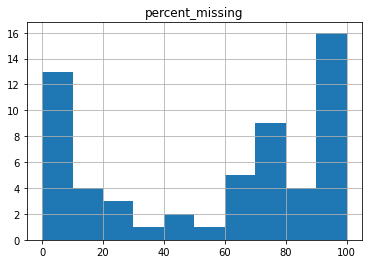

In [61]:
missing_value_df.hist()

# we see that two of the columns are entirely null, with a few that are almost entirely null.

How many columns are 90%+ NaN? Input your answer into q3cii_str as a string (e.g. if your answer is 6, then `q3cii_str = "6"`)

<!--
BEGIN QUESTION
name: q3cii
points: 1
-->

In [62]:
val = sum(missing_value_df["percent_missing"] >= 90)
val

16

In [63]:
q3cii_str = "16"

In [64]:
grader.check("q3cii")

q3cii passed!

### Question 3d

Let us now alter `business_df` to exclude the columns with more than 80%+ null values. This likely means the corresponding attributes are not an important factor for most businesses so we can get rid of them in our `business_df`. Create a new dataframe 
called `important_attribute_business_df` which only contains these columns. It might be useful to use `missing_value_df` from the previous subpart!

In [65]:
vals = missing_value_df[missing_value_df["percent_missing"] < 80]["column_name"]
important_attribute_business_df = business_df[list(vals)]
important_attribute_business_df

,_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,attributes.WiFi,attributes.BusinessParking,attributes.Alcohol,hours.Monday,hours.Tuesday,hours.Wednesday,hours.Thursday,hours.Friday,hours.Saturday,hours.Sunday
0,608c91c0bd041ab900f9e081,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,...,u'free',"{'garage': True, 'street': False, 'validated':...",u'beer_and_wine',5:0-18:0,5:0-17:0,5:0-18:0,5:0-18:0,5:0-18:0,5:0-18:0,5:0-18:0
1,608c91c0bd041ab900f9e082,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,...,NaN,"{'garage': False, 'street': True, 'validated':...",NaN,NaN,NaN,NaN,11:0-18:0,11:0-18:0,11:0-18:0,11:0-18:0
2,608c91c0bd041ab900f9e083,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,608c91c0bd041ab900f9e084,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,...,NaN,"{'garage': False, 'street': False, 'validated'...",NaN,16:0-19:0,16:0-19:0,16:0-19:0,16:0-19:0,16:0-19:0,9:0-11:0,NaN
4,608c91c0bd041ab900f9e085,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,...,u'no',"{'garage': False, 'street': True, 'validated':...",u'none',17:0-21:0,17:0-21:0,17:0-21:0,17:0-21:0,17:0-21:0,17:0-21:0,17:0-21:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,608c91c1bd041ab900f9e463,HQ1fwOWzYK5zSxTGSwSvmw,Dunkin',99 Cambridge St,Charlestown,MA,02129,42.382539,-71.079236,2.0,...,'free',"{'garage': False, 'street': True, 'validated':...",NaN,5:0-23:0,5:0-23:0,5:0-23:0,5:0-23:0,5:0-23:0,5:0-23:0,5:0-23:0
995,608c91c1bd041ab900f9e464,LOiS95cRQbPrbRZ2-fMXbg,Shane's Rib Shack,1221 Caroline St,Atlanta,GA,30307,33.758258,-84.348474,3.0,...,'free',"{'garage': False, 'street': True, 'validated':...",u'none',11:0-21:0,11:0-21:0,11:0-21:0,11:0-21:0,11:0-21:0,11:0-21:0,11:0-21:0
996,608c91c1bd041ab900f9e465,9irir2PpYr_yY5lNWYqUWA,Subaru North Orlando,4113 S Orlando Dr,Sanford,FL,32773,28.749161,-81.291087,4.0,...,u'free',NaN,NaN,10:0-18:0,8:30-20:0,8:30-20:0,8:30-20:0,8:30-20:0,8:30-18:0,NaN
997,608c91c1bd041ab900f9e466,2cG2YiR8Tg-YCJJfaHJtYw,Elements Massage - Medford,40 High St,Medford,MA,02155,42.418388,-71.111116,4.0,...,NaN,"{'garage': False, 'street': True, 'validated':...",NaN,9:0-21:0,9:0-21:0,9:0-21:0,9:0-21:0,9:0-21:0,9:0-21:0,9:0-21:0


In [66]:
# Do not delete/edit this cell
important_attribute_business_df.to_csv('results/result_3d.csv', index=False)

In [67]:
grader.check("q3d")

q3d passed!

### Question 3e

At this point, you have had experience with manipulating data on Mongo, Postgres, and Pandas. In this question, we will provide 3 scenarios and using the lessons you've learned so far, please specify which of the three (Mongo, Postgres, or Pandas) would work best for this specific use case.

1. You are doing a data journalism piece on college sports. You collect a list of colleges and for each collegiate sport program within that college, you find the budget assigned for that program. You have a choice between the following:

    A) Representing this data in JSON (e.g. 
    ```
    {
        "UC Berkeley": {
            "football": "10000000", 
            "wrestling": "344582", 
            ...}
    }
    ```
    ) and importing into Mongo.
    
    B) Representing this data as a schema in Postgres where the columns are the names of the sports.
    
    C) Representing this data as a dataframe in Pandas where the columns are the names of the sports.

You would like to find the aggregate of budgets across different sports (average, sum, median, mode). What would be the best option for storing this data?

**NOTE**: Your answer should look like `q3ei_str = ['A']` or `q3ei_str = ['B']` or `q3ei_str = ['C']` or `q3ei_str = ['D']`

<!--
BEGIN QUESTION
name: q3ei
points: 1
-->

In [68]:
q3ei_str = ['B']

In [69]:
grader.check("q3ei")

q3ei passed!

2. You would now like to investigate what effect does budget have on student-athlete scholarships. After doing some research, you find a dataset that contains a list of every single athlete at every single college and their sport and scholarship levels (this is a massive 10GB+ dataset with millions of rows). You find another dataset that contains a list of colleges, their sports programs, and the program budget. This is another massive dataset with hundreds of thousands of rows. You would like to perform an inner join between the two datasets on school and program so you can view each student-athlete's scholarship with their sport's budget. You have a choice between the following:

    A) Representing each dataset in JSON (e.g. 
    ```
    {"athletes": [
        {"Chase Garbers": {
            "school": "UC Berkeley", 
            "scholarship": "full", 
            "sport": "football", 
            ...
            }
        }, 
        ...
    ]}
    ```
    and 
    ```
    {"schools": [
        {"UC Berkeley": {
            "football": {
                "budget": "10000000"
             }, 
             ...
             }
        }, 
        ...
     ]}
     ```
    ), importing into Mongo, and doing a join there.
    
    B) Representing this data as 2 schemas in Postgres where the columns for the first schema are 
    [`student_name`, `school`, `sport`, `scholarship`] and for the second [`school`, `sport`, `budget`].
    
    C) Representing this data as 2 dataframes in Pandas with the same columns as Postgres.

What would be the best option for storing this data?

**NOTE**: Your answer should look like `q3eii_str = ['A']` or `q3eii_str = ['B']` or `q3eii_str = ['C']` or `q3eii_str = ['D']`

<!--
BEGIN QUESTION
name: q3eii
points: 1
-->

In [70]:
q3eii_str = ['B']

In [71]:
grader.check("q3eii")

q3eii passed!

3. Finally, you are ready to start writing your article! You decide to focus on just the data from UC Berkeley. You have access to a dataset of just UC Berkeley athletes along with their sports and scholarship levels. The scholarship level data was improperly cleaned: some scholarships are recorded as strings "full", "half", or "none" and some are recorded as integer percentages 0-100. You would like to provide this data to your readers in a format that is susceptible to easy visualizations: e.g. graphs that show how many athletes have a full vs. half vs. no scholarship, which sports have the highest percentages of athletes with full scholarships etc. What is the best way to store this data for this purpose?

    A) Represent the dataset in JSON e.g.
    ```
    {"athletes": [
        {
           "Chase Garbers": {
             "scholarship": "full", 
             "sport": "football"
           }
        },
        {
            "Danielle Vosk": {
              "scholarship": 25,
              "sport": "basketball"
            }
        },
        ...
        ]
    }
    ```
    B) Represent this data as a schema in Postgres where the columns are [`student_name`, `sport`, `scholarship`]
    
    C) Represent this data as a dataframe in Pandas with the same columns as Postgres.
    
**NOTE**: Your answer should look like `q3eiii_str = ['A']` or `q3eiii_str = ['B']` or `q3eiii_str = ['C']` or `q3eiii_str = ['D']`

<!--
BEGIN QUESTION
name: q3eiii
points: 1
-->

In [72]:
q3eiii_str = ['C']

In [73]:
grader.check("q3eiii")

q3eiii passed!

## Question 4: Messy JSON

### Question 4a
Many of the queries you've seen or written thus far were relatively reliable: aggregating and collecting over fields
that you know exist for sure. But the nature of Mongo documents is that they are inherently flexible and semi-structured. Not every document will share every single field! In this question, we will explore how Mongo handles these use cases.

For this question and the rest of Q4, please use the `businesses` collection (this should be stored in the `business` Python variable).

Imagine you are in charge of managing your family reunion. You would like to book a private room at a restaurant.
However, you would also like to optimize for chaos. You notice that there is an attribute called `RestaurantsGoodForGroups`. You would like to write a query that returns all restaurants that **do not** have the `RestaurantsGoodForGroups` attribute so that the trajectory of the reunion is determined by fate. Your output for the autograder will be the number of restaurants that do not have the `RestaurantsGoodForGroups` attribute stored in `q4a_str`. 

**NOTE: You would like this list to consist solely of restaurants. This means that the business must have `Restaurants` in the `categories` field.**

In [74]:
len(list(business.aggregate([{"$match" : {"$text" : {"$search" : "Restaurants"},
            "attributes.RestaurantsGoodForGroups" : {"$exists" : False}}}])))

8237

In [75]:
# The following text index may be useful!
if 'categories_text' not in business.index_information():
    business.create_index([('categories', TEXT)])

# YOUR ANSWER HERE
pipeline = [{"$match" : {"$text" : {"$search" : "Restaurants"},
            "attributes.RestaurantsGoodForGroups" : {"$exists" : False}}}]

How many restaurants do not have the `RestaurantsGoodForGroups` attribute? You may either enter input this is a function with respect to your query or hardcode in either the String or the numeric version of the answer you computed.

In [76]:
q4a_str = len(list(business.aggregate(pipeline)))
q4a_str

8237

In [77]:
# Do not delete/edit this cell
pickle.dump(q4a_str, open("results/result_4a.p","wb"))

In [78]:
grader.check("q4a")

q4a passed!

### Question 4b

Your relatives inform you that they would like to be at the restaurant when it opens to beat the crowds. Furthermore, after sending
a when2meet, most of your relatives would prefer for the meal to be on a Friday and the start time of the meal to be 
between 5-6:59PM (17:00-18:59). Find the number of restaurants that open on Fridays between 17:00-18:59 and store this in a variable labelled `q4b_str`. As a reminder, in order for a business to be a restaurant, it must have `Restaurant` in its categories. Be aware that `hours` can either be an array or `None`!

**HINT**: It will be advantageous to use the `aggregate()` Pymongo function along with the `$addFields` (adds a new field to documents) and `$match` (filters out documents based on a condition) stage operators.You may also want to use the `$split` operator (similar to Python's string `split()` function) to parse out the Friday hours.

In [79]:
line = [{'$match': { "$text": {"$search": "Restaurants"}}},
        {'$project': {'name':1, 'hrSub': { '$substr': [ "$hours.Friday", 0, 2 ] }}},
        {'$match': {  '$or': [ { 'hrSub' : "17" }, { 'hrSub' : "18" } ] }}]
len(list(business.aggregate(line)))

3348

In [80]:
# BEGIN QUERY HERE
pl_b = [{'$match': { "$text": {"$search": "Restaurants"}}},
        {'$project': {'name':1, 'hrSub': { '$substr': [ "$hours.Friday", 0, 2 ] }}},
        {'$match': {  '$or': [ { 'hrSub' : "17" }, { 'hrSub' : "18" } ] }}]
cursor = business.aggregate(pl_b)

How many restaurants open on Fridays between 17:00-18:59?

In [81]:
q4b_str = len(list(cursor))
q4b_str

3348

In [82]:
# Do not delete/edit this cell
pickle.dump(q4b_str, open("results/result_4b.p","wb"))

In [83]:
grader.check("q4b")

q4b passed!

### Question 4c

Some members of your family are vegetarian so you would like to only eat at restaurants with the Vegetarian category. 
However, the `categories` are stored as a single string! You would like to make it easy to access Vegetarian as a separate field. Write a query that does the following: for every category in `categories`, add a new document that contains the category as a field with the value `'true'`, the `ObjectId` for the previous document (labelled `_id`), and the name of the business (labelled `name`).

For example, a document 
```
{
    "_id": ObjectId('606ffb0123cf2e5079dbd91f'), 
    "name": "Wendy's", 
     ..., 
     categories" : "Salad, Vegetarian"
} 
```
would become 
```
{
    “Salad”: "true", 
    "_id": ObjectId('606ffb0123cf2e5079dbd91f'), 
    "name": "Wendy's"
}
```
and 
```
{
    “Vegetarian”: "true", 
    "_id": ObjectId('606ffb0123cf2e5079dbd91f'), 
    "name": "Wendy's"
}
```

We will save your pipeline to a variable called `q4c_pipeline`. **Do not change this variable name or you won't pass the autograder!** This query should be of the form `business.aggregate(q4c_pipeline)`. In order to get full credit, you will need to enter your pipeline into the variable `q4c_pipeline`. 

In [86]:
q4c_pipeline = [{"$addFields" : {"new_categories" : {"$split" : ["$categories", ", "]}}},
                {"$unwind" : "$new_categories"},
                {"$addFields" : {"categories" : [["$new_categories", "true"], 
                                                 ["_id", "$id"],
                                                 ["name", "$name"]]}}, 
                {"$addFields" : {"categories" : {"$arrayToObject" : "$categories"}}},
                {"$replaceRoot" : {"newRoot" : "$categories"}}]

cur = business.aggregate(q4c_pipeline)

In [87]:
# Do not delete/edit this cell
myclient = pymongo.MongoClient("mongodb://localhost")
mydb = myclient["yelp"]
business = mydb["businesses"]
pipeline_for_test_4c = q4c_pipeline[:]
pipeline_for_test_4c.extend([{"$match": {"name": "Everything POP Shopping & Dining"}}, {"$project": {"_id": 0}}])
cur_test_4c = business.aggregate(pipeline_for_test_4c)
pickle.dump(list(cur_test_4c), open("results/result_4c.p","wb"))

pipeline_for_test_4c_2 = q4c_pipeline[:]
pipeline_for_test_4c_2.extend([{"$match": {"name": "Longwood Galleria"}}, {"$project": {"_id": 0}}])
cur_test_4c_2 = business.aggregate(pipeline_for_test_4c_2)
pickle.dump(list(cur_test_4c_2), open("results/result_4c_2.p","wb"))

In [88]:
grader.check("q4c")

q4c passed!

### Question 4d
This change in representation has made it super easy to view all the vegetarian restaurants and count them without the use of an index since
we can now simply filter by whether or not 'Vegetarian' is a field in our document! We have provided some code here to
count how many vegetarian restaurants are in our dataset. Simply provide the actual number, in either string or numeric format, to get points for this question.

In [89]:
# Question 4d
myclient = pymongo.MongoClient("mongodb://localhost")
mydb = myclient["yelp"]
business = mydb["businesses"]
pipeline_for_4d = q4c_pipeline[:]
pipeline_for_4d.append({"$match": {"Vegetarian": 'true'}})
cur_for_4d = business.aggregate(pipeline_for_4d)

veg_count = len(list(cur_for_4d))

In [90]:
# Do not delete/edit this cell
pickle.dump(veg_count, open("results/result_4d.p","wb"))

In [91]:
grader.check("q4d")

q4d passed!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [92]:
grader.check_all()

q1a passed!

q1b passed!

q1c passed!

q1d passed!

q1e passed!

q1f passed!

q2b passed!

q2ci passed!

q2cii passed!

q3b passed!

q3ci passed!

q3cii passed!

q3d passed!

q3ei passed!

q3eii passed!

q3eiii passed!

q4a passed!

q4b passed!

q4c passed!

q4d passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()

## Results

Your Gradescope submission will require a results.zip file. Run the following cell to generate this file.

In [ ]:
!zip -r results.zip results